# Running this notebook

`bazel build Projects:jupyter && ./bazel-bin/Projects/jupyter`

In [97]:
# Generate 3D random rotations
from scipy.spatial.transform import Rotation as R
from vonMisesFisher.vonMisesFisher import vMF
from lib.Transforms.SO3 import SO3

# Plot the rotations
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from itertools import product, combinations


def produce_rotation_matrix(choice):
    if choice == "vMF":
        v = vMF.samplevMF(kappa = 6000)
        v_in_algebra = SO3.so3(v)
        V_SO3 = v_in_algebra.exp_map_euler()
        return V_SO3.R
    
    else:
        rot = R.from_euler("xy", R.random().as_euler("xyz")[:2]).as_matrix()
        return rot
        

rotations_matrix = []
rotations_SO3 = []
rotations_roll = []
rotations_pitch = []
rotations_yaw = []

for i in range(100):
    random_rot = produce_rotation_matrix("vMF")
    rotations_matrix.append(random_rot)
    rotations_SO3.append(SO3.SO3(random_rot))
    y, p, r = R.from_matrix(random_rot).as_euler("xyz")
    rotations_roll.append(r)
    rotations_pitch.append(p)
    rotations_yaw.append(y)
    
# noise
r_noise = R.from_euler('y', -3, degrees=True).as_matrix()
for i in range(30):
    random_rot = produce_rotation_matrix("vMF")
    random_rot = r_noise @ random_rot @ r_noise.T
    rotations_matrix.append(random_rot)
    rotations_SO3.append(SO3.SO3(random_rot))
    y, p, r = R.from_matrix(random_rot).as_euler("xyz")
    rotations_roll.append(r)
    rotations_pitch.append(p)
    rotations_yaw.append(y)
    

In [98]:
from lib.Transforms.SO3.SO3_utils import SO3_mean, SO3_median

mean_from_SO3 = SO3_mean(rotations_SO3)
median_from_SO3 = SO3_median(rotations_SO3, S_t = mean)

mean_from_SO3_in_ypr = mean_from_SO3.log_map().w
median_from_SO3_in_ypr = median_from_SO3.log_map().w

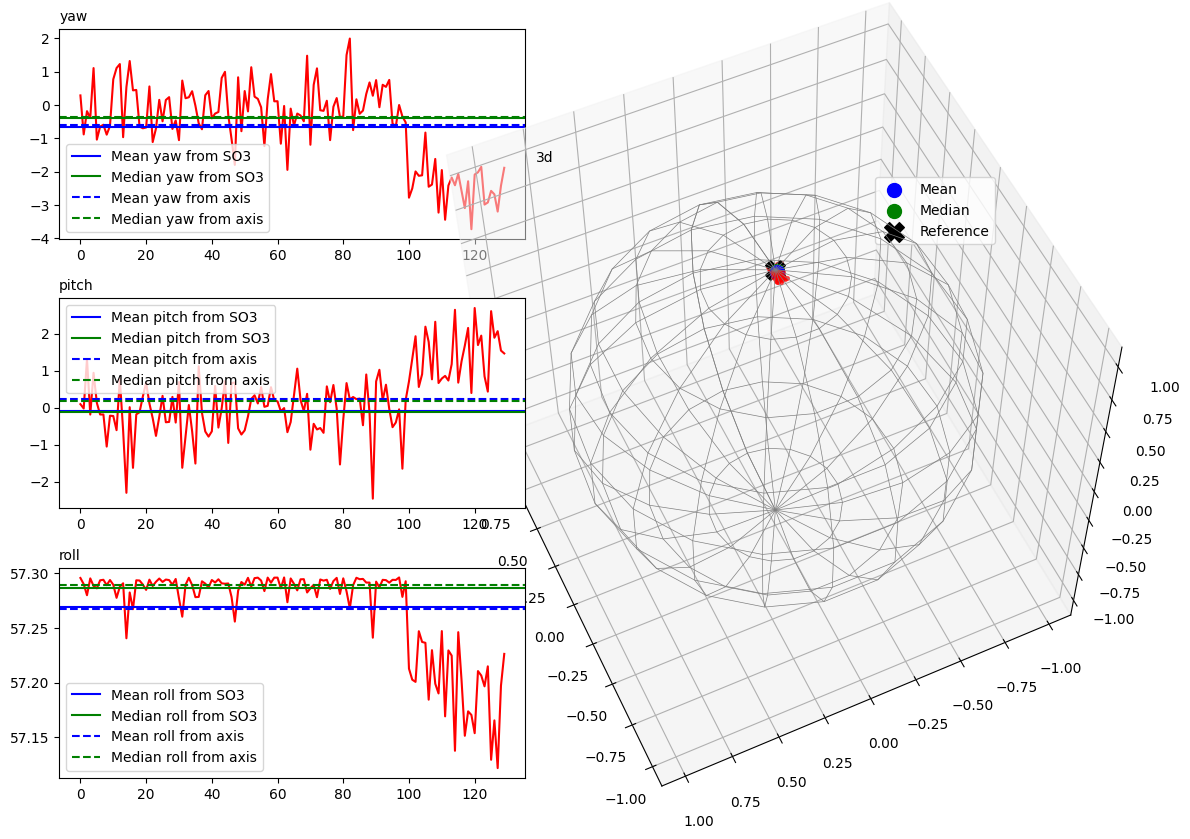

In [99]:
fig, axd = plt.subplot_mosaic([['yaw', '3d'],
                               ['pitch', '3d'],
                               ['roll', '3d']],
                              figsize=(10, 8), layout="constrained",
                              per_subplot_kw = {"3d": {"projection":"3d"}})

axd["3d"].view_init(elev=55., azim=155)

colors = {"mean": "b", "median": "g"}    

# draw sphere
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)

axd["3d"].set_box_aspect((np.ptp(x), np.ptp(y), np.ptp(z)), zoom = 1.7)
axd["3d"].plot_wireframe(x, y, z, linewidth = 0.5, color="grey")


x, y, z  = mean_from_SO3.log_map().w
axd["3d"].scatter(x, y, z, color = colors["mean"], s = 100, label = "Mean")
x, y, z  = median_from_SO3.log_map().w
axd["3d"].scatter(x, y, z, color = colors["median"], s = 100, label = "Median")
axd["3d"].scatter(0, 0, 1, color = "k", s = 200, marker = "X", label = "Reference")

# draw a point
for rotation in rotations_SO3:
    x, y, z = rotation.log_map().w
    axd["3d"].scatter(x, y, z, color="r", s=7, alpha = 0.6)


x = [x for x in range(len(rotations_pitch))]
index_to_axd = ["yaw", "pitch", "roll"]
for i, y in enumerate([rotations_yaw, rotations_pitch, rotations_roll]):
    axd[index_to_axd[i]].plot(x, np.degrees(y), c = "r", label = "")
    # from SO3
    axd[index_to_axd[i]].axhline(np.degrees(mean_from_SO3_in_ypr[i]), c = colors["mean"], label = f"Mean {index_to_axd[i]} from SO3")
    axd[index_to_axd[i]].axhline(np.degrees(median_from_SO3_in_ypr[i]), c = colors["median"], label = f"Median {index_to_axd[i]} from SO3")
    # axis wise
    axd[index_to_axd[i]].axhline(np.degrees(np.mean(y)), linestyle = "--", c = colors["mean"], label = f"Mean {index_to_axd[i]} from axis")
    axd[index_to_axd[i]].axhline(np.degrees(np.median(y)), linestyle = "--",c = colors["median"], label = f"Median {index_to_axd[i]} from axis")
    


for label, ax in axd.items():
    ax.set_title(label, loc='left', fontsize='medium')
    ax.legend()
    
plt.show()